In [2]:
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import pandas as pd
from typing import Optional, Dict
from dim_est.analysis.plotting_functions_infinite_data import *
from tqdm import tqdm
import matplotlib as mpl
from dim_est.datasets.data_generation import make_data_generator
from dim_est.run.run_dsib_single_experiment import merge_with_validation
from dim_est.config.dataset_defaults import DATASET_DEFAULTS 
from cca_zoo.linear import CCA
import copy

from tqdm import tqdm

from cca_mi_estimation import generate_CCA_mi_estimate
# Global defaults for entire notebook
mpl.rcParams.update({
    "figure.figsize": (5, 5),
    "figure.dpi": 150,
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

/users/pgulat4/.conda/envs/MI_estimation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_mi_vs_kz_from_df(
    ax,
    results_df,
    *,
    group_keys=("critic_type", "experiment_cfg.dataset.cfg.transform.sig_embed_x"),
    x_key="kz",
    y_key="max_smoothed_info",
    yerr_key="std_smoothed_info",
    label_fn=None,
    title: Optional[str] = None,
    true_dim: Optional[int] = None,
):
    """
    Plot max-smoothed MI vs k_z from an already-built DataFrame.

    Assumes `results_df` already has columns:
      - x_key           (default 'kz')
      - y_key           (default 'max_smoothed_info')
      - yerr_key        (default 'std_smoothed_info')
      - group_keys      (e.g. 'critic_type', noise level, etc.)
    """
    if results_df is None or results_df.empty:
        ax.text(0.5, 0.5, "No matching runs", ha="center", va="center")
        ax.set_xlabel(r"$k_z$")
        ax.set_ylabel(r"$I_{\rm est}$")
        if title:
            ax.set_title(title)
        return

    if isinstance(group_keys, str):
        group_keys = (group_keys,)          
    else:
        group_keys = tuple(group_keys)

    # Default label_fn: turn group values into a readable string
    if label_fn is None:
        def label_fn(group_vals: tuple):
            parts = []
            for k, v in zip(group_keys, group_vals):
                parts.append(f"{k}={v}")
            return ", ".join(parts)

    for group_vals, df_sub in results_df.groupby(list(group_keys)):
        # scatter + error bars for all runs in this group
        axerr, _, _ = ax.errorbar(
            df_sub[x_key],
            df_sub[y_key],
            yerr=df_sub[yerr_key],
            fmt="o",
            alpha=0.2,
        )

        # aggregate over repeated kz (e.g. max over trials)
        agg = (
            df_sub.groupby(x_key)[y_key]
            .agg(["max"])
            .reset_index()
        )

        label = label_fn(group_vals)

        ax.plot(
            agg[x_key],
            agg["max"],
            label=label,
            linewidth=1.5,
            c=axerr.get_color(),
        )
        ax.scatter(
            agg[x_key],
            agg["max"],
            c=axerr.get_color(),
            alpha=1.0,
        )

    ax.set_xlabel(r"$k_z$")
    ax.set_ylabel(r"$I_{\rm est}$")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if title:
        ax.set_title(title)
    if true_dim is not None:
        ax.axvline(true_dim, ls="--", c="k", alpha=0.2)
    ax.legend()

In [12]:
def plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= "linear", do_CCA: bool = True, CCA_n_samples: int = 10_000, CCA_kz_list = range(1,11), dataset_type = "joint_gaussian", ds_cfg={}, cca_cache = "cca_mi_estimates.h5", use_cache=True, write_to_cache = True):
    
    dataset_type = 'joint_gaussian'
    mi_bits = 2.0   
    latent_dim = 4
    
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable", "separable_augmented"],
    }
    
    extra_filters = {
        "params.experiment_cfg.dataset.cfg.latent.latent_dim": latent_dim,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits": mi_bits,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",
        include_meta_keys=[
            "tags.kz",
        ]
    )

    Nx = ds_cfg["transform"]["observe_dim_x"]
    
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
            critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
            return rf"{critic_type}"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=latent_dim
    )

    if do_CCA:
        mi_list = []

        data_generator = make_data_generator(dataset_type, ds_cfg, device="cpu")
        
        for kz in tqdm(CCA_kz_list, desc= "generating CCA estimates (or loading from cache)"):
            mi_kz = generate_CCA_mi_estimate(data_generator, ds_cfg, CCA_n_samples, kz, cache_path = cca_cache, use_cache=use_cache, write_to_cache = write_to_cache)
            mi_list.append(mi_kz)
        
        ax.plot(CCA_kz_list, mi_list, label = r'CCA', c='r')
        ax.scatter(CCA_kz_list, mi_list, c='r')
        ax.legend()
        

        
        

In [13]:
def plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= "linear", do_CCA: bool = True, CCA_n_samples: int = 10_000, CCA_kz_list = range(1,11), dataset_type = "gaussian_mixture", ds_cfg={}, cca_cache = "cca_mi_estimates.h5", use_cache=True, write_to_cache = True):
    dataset_type = 'gaussian_mixture'
    n_peaks = 8 
    mu = 2.0
    mi_bits_peak = 2.0
    
    
    sweep_tags = {
        "tags.dataset_type": [dataset_type],
        "tags.critic_type": ["hybrid", "separable", "separable_augmented"],
    }
    
    extra_filters = {
        # "tags.n_iter": n_iter,
        "params.experiment_cfg.dataset.cfg.latent.n_peaks": n_peaks,
        "params.experiment_cfg.dataset.cfg.latent.mu": mu,
        "params.experiment_cfg.dataset.cfg.latent.mi_bits_peak": mi_bits_peak,
        "params.experiment_cfg.dataset.cfg.transform.mode": transform_mode,
        "tags.estimator": "lclip",
    }
    
    results_df = load_mi_summary(
        outfile=outfile,
        sweep_tags=sweep_tags,
        extra_filters=extra_filters,
        metric_key="mi_bits",
        include_meta_keys=[
            "tags.kz",
        ]
    )
    
    Nx = ds_cfg["transform"]["observe_dim_x"]
    title = rf"{dataset_type}, $F^{{\mathrm{{{transform_mode}}}}} \rightarrow \mathbb{{R}}^{{{Nx}}} $"
    
    def label_fn(group_vals):
            critic_type, = group_vals ## group_vals is always a tuple (read with the comma)
            return rf"{critic_type}"
    
    plot_mi_vs_kz_from_df(
        ax,
        results_df,
        group_keys=["critic_type"],
        x_key="kz",
        y_key="max_smoothed_info",
        yerr_key="std_smoothed_info",
        label_fn=label_fn,
        title=title,
        true_dim=1
    )


    if do_CCA:
        mi_list = []
        data_generator = make_data_generator(dataset_type, ds_cfg, device="cpu")        
        for kz in tqdm(CCA_kz_list, desc= "generating CCA estimates (or loading from cache)"):
            mi_kz = generate_CCA_mi_estimate(data_generator, ds_cfg, CCA_n_samples, kz, cache_path = cca_cache, use_cache=use_cache, write_to_cache = write_to_cache)
            mi_list.append(mi_kz)
        
        ax.plot(CCA_kz_list, mi_list, label = r'CCA', c='r')
        ax.scatter(CCA_kz_list, mi_list, c='r')
        ax.legend()
        

    
    

generating CCA estimates (or loading from cache): 100%|██████████| 14/14 [00:00<00:00, 173.88it/s]


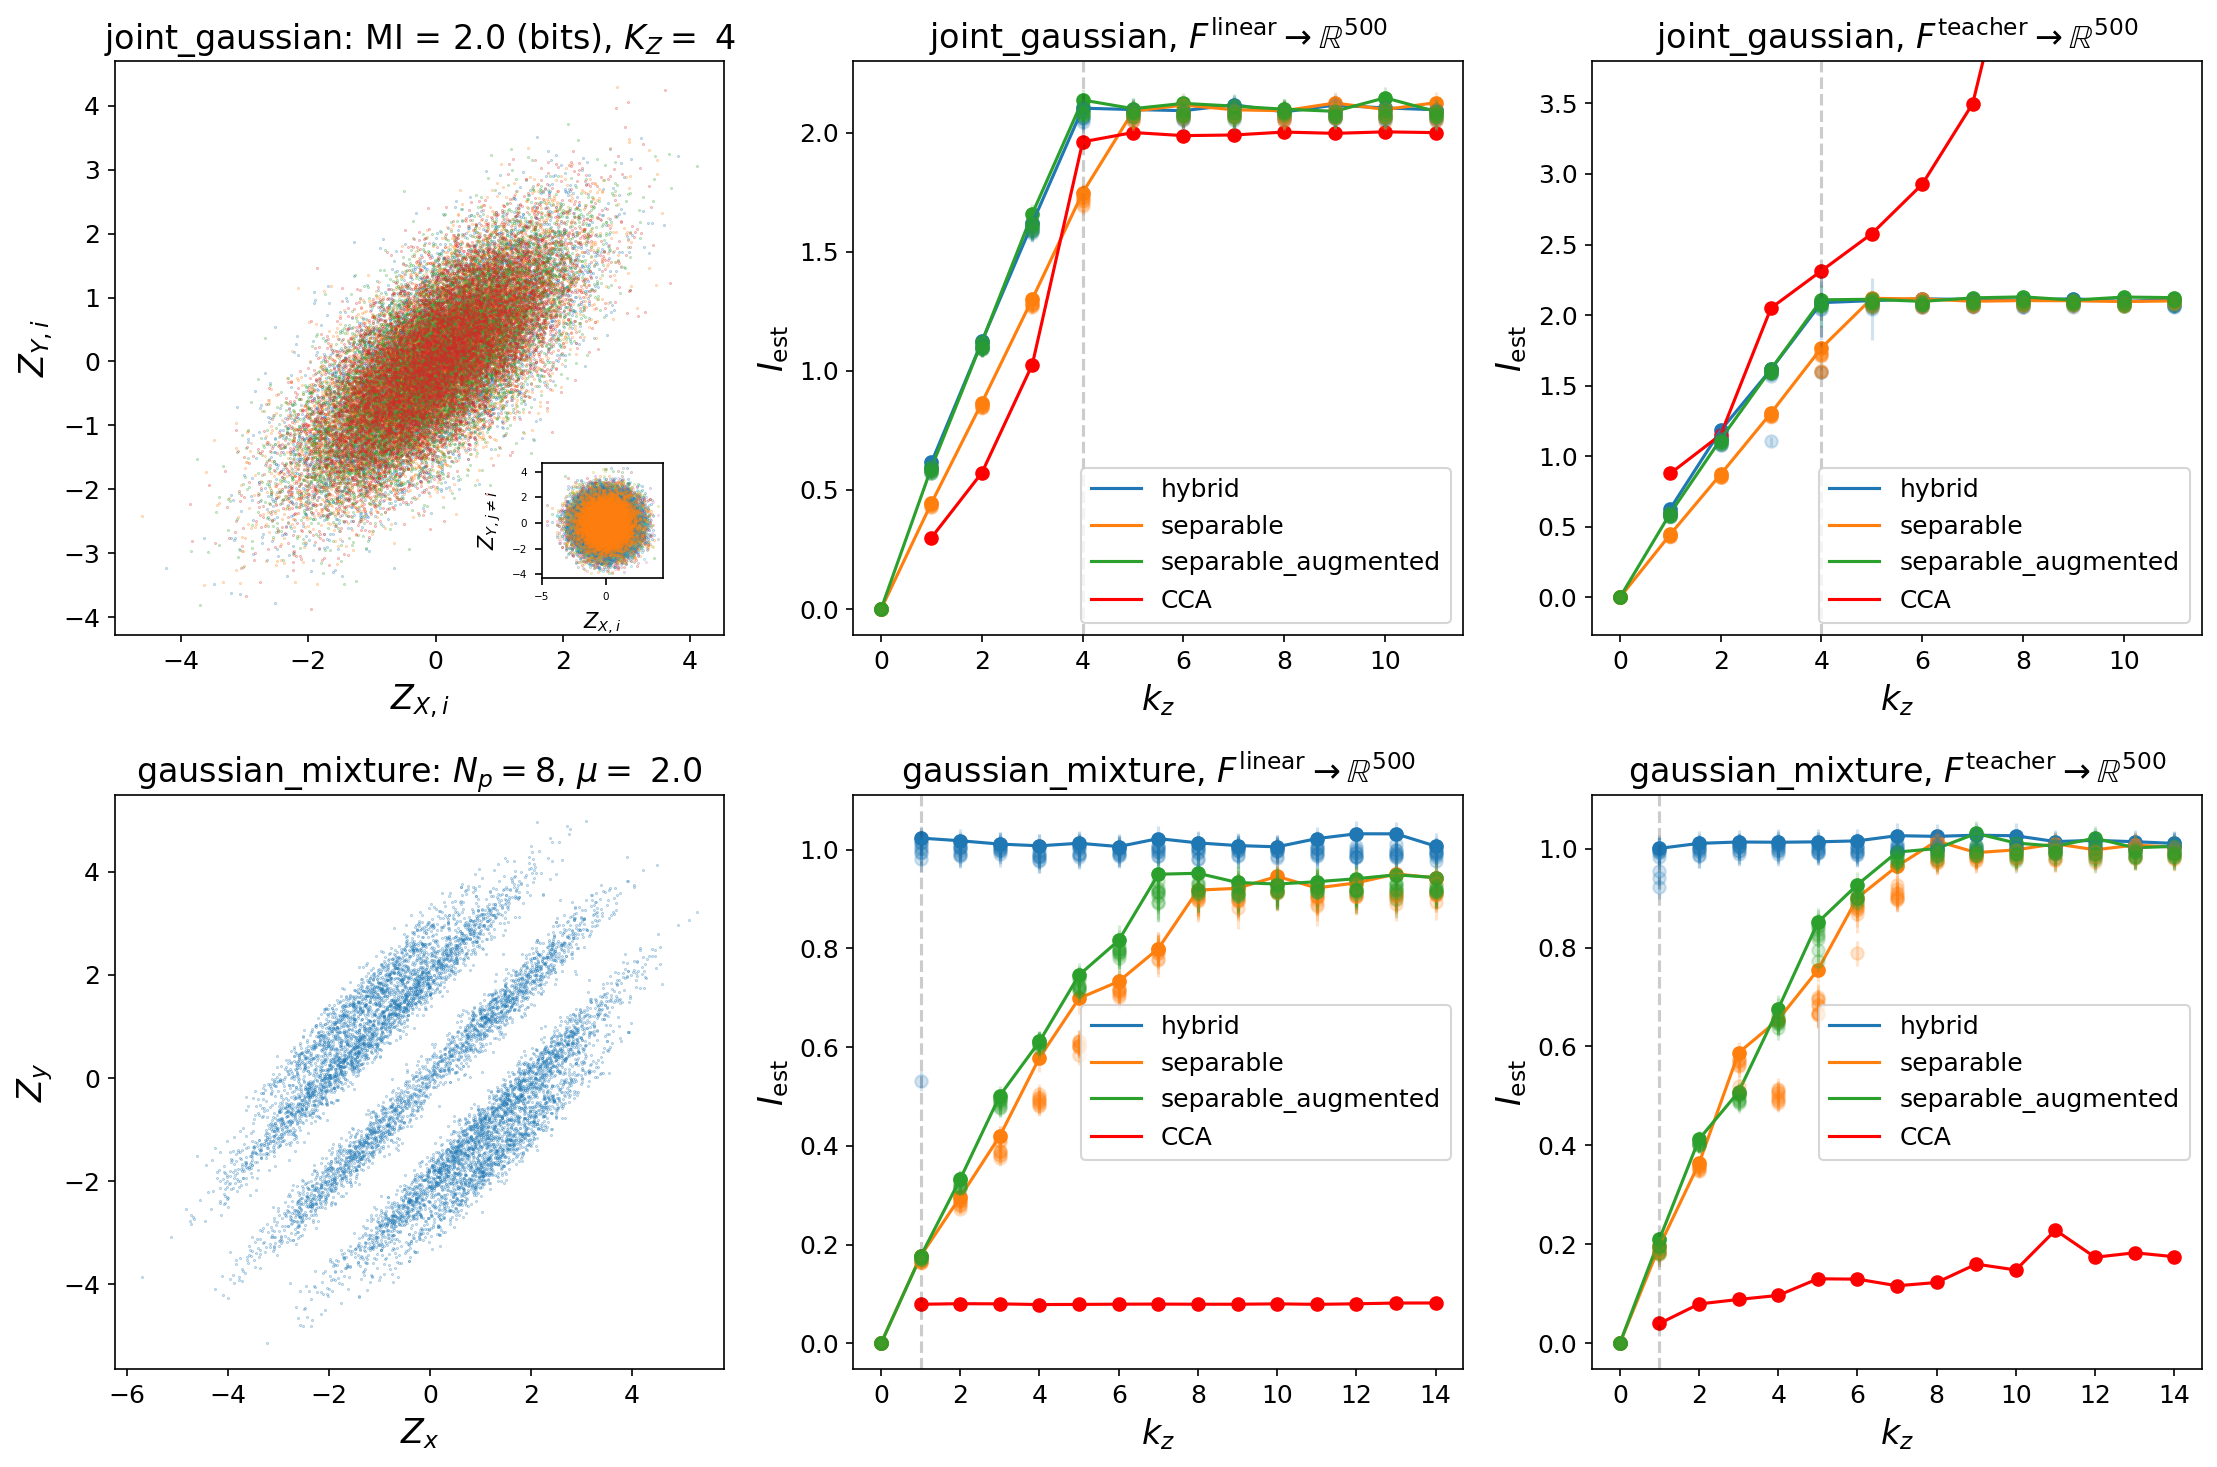

In [23]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

dataset_type = "joint_gaussian"

ax = axes[0,0]

latent_dim = 4
mi_bits = 2.0
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))

ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')
zx, zy = data_generator(10000)
for i in range(latent_dim):
    ax.scatter(zx[:, i], zy[:, i], alpha=0.5, s=0.1)# c= '#1f77b4'
    
ax.set_xlabel(r"$Z_{X, i}$")
ax.set_ylabel(r"$Z_{Y, i}$")

axin = ax.inset_axes([0.7, 0.1, 0.2, 0.2], transform =ax.transAxes)
for i in range(latent_dim):
    for j in range(latent_dim):
        if i!=j:
            axin.scatter(zx[:, i], zy[:, j], alpha=0.5, s=0.1)
    
axin.set_xlabel(r"$Z_{X, i}$", fontsize=10)
axin.set_ylabel(r"$Z_{Y, j\ne i}$", fontsize=10)
axin.tick_params(axis='both', which='major', labelsize=5)
ax.set_title(rf'{dataset_type}: MI = {mi_bits} (bits), $K_Z = $ {latent_dim}')


ax = axes[0, 1]
transform_mode = "linear"
outfile = "h5_results/infinite_data_joint_gaussian_linear_transform.h5"
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode=transform_mode, observe_dim_x =500, observe_dim_y =500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 200_000, CCA_kz_list = range(1,12), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = "cca_mi_estimates.h5")


ax = axes[0, 2]
transform_mode = "teacher"
outfile = "h5_results/infinite_data_joint_gaussian_teacher_transform.h5"
dataset_overrides = dict(latent=dict(latent_dim=latent_dim, mi_bits=mi_bits), transform = dict(mode=transform_mode, observe_dim_x =500, observe_dim_y =500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_joint_gaussian_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 200_000, CCA_kz_list = range(1,12), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = "cca_mi_estimates.h5")

ax.set_ylim(top=3.8)

# ##############################################
ax = axes[1,0]

dataset_type = "gaussian_mixture"
n_peaks = 8 
mu =2.0
mi_bits_peak = 2.0
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='identity', observe_dim_x =None, observe_dim_y =None))
ds_defaults = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
data_generator = make_data_generator(dataset_type, ds_cfg, device = 'cpu')

zx, zy = data_generator(10000)

ax.scatter(zx, zy, alpha=0.5, s=0.1)
ax.set_xlabel(r"$Z_x$")
ax.set_ylabel(r"$Z_y$")
ax.set_title(rf'{dataset_type}: $N_p = ${n_peaks}, $\mu = $ {mu}')

ax = axes[1, 1]
transform_mode = "linear"
outfile = "h5_results/infinite_data_gaussian_mixture_linear_transform.h5"
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='linear', observe_dim_x = 500, observe_dim_y = 500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 200_000, CCA_kz_list = range(1,15), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = "cca_mi_estimates.h5")

ax = axes[1, 2]
transform_mode = "teacher"
outfile = "h5_results/infinite_data_gaussian_mixture_teacher_transform.h5"
dataset_overrides = dict(latent=dict(n_peaks=n_peaks, mi_bits_peak=mi_bits_peak, mu= mu, sig=1.0), transform = dict(mode='teacher', observe_dim_x = 500, observe_dim_y = 500))
ds_cfg = merge_with_validation(ds_defaults, dataset_overrides, "dataset overrides")
plot_mi_vs_kz_gaussian_mixture_panel(ax, outfile, transform_mode= transform_mode, do_CCA = True, CCA_n_samples = 200_000, CCA_kz_list = range(1,15), dataset_type = dataset_type, ds_cfg=ds_cfg, cca_cache = "cca_mi_estimates.h5")


# ##############################################

plt.tight_layout()
plt.show()